In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from covid19dh import covid19
world, src = covid19(verbose=False)

In [197]:
raw, src_raw = covid19(verbose=False) # debug purpose
len(raw.columns)

47

## Spain

In [3]:
world.head()

,id,date,confirmed,deaths,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,hosp,...,iso_alpha_3,iso_alpha_2,iso_numeric,iso_currency,key_local,key_google_mobility,key_apple_mobility,key_jhu_csse,key_nuts,key_gadm
19401,0094b645,2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LCA,LC,662.0,XCD,NaN,NaN,NaN,LC,NaN,LCA
19402,0094b645,2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LCA,LC,662.0,XCD,NaN,NaN,NaN,LC,NaN,LCA
19403,0094b645,2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LCA,LC,662.0,XCD,NaN,NaN,NaN,LC,NaN,LCA
19404,0094b645,2020-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LCA,LC,662.0,XCD,NaN,NaN,NaN,LC,NaN,LCA
19405,0094b645,2020-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LCA,LC,662.0,XCD,NaN,NaN,NaN,LC,NaN,LCA


In [199]:
world.shape

(187451, 47)

In [200]:
world.columns

Index(['id', 'date', 'confirmed', 'deaths', 'recovered', 'tests', 'vaccines',
       'people_vaccinated', 'people_fully_vaccinated', 'hosp', 'icu', 'vent',
       'school_closing', 'workplace_closing', 'cancel_events',
       'gatherings_restrictions', 'transport_closing',
       'stay_home_restrictions', 'internal_movement_restrictions',
       'international_movement_restrictions', 'information_campaigns',
       'testing_policy', 'contact_tracing', 'facial_coverings',
       'vaccination_policy', 'elderly_people_protection',
       'government_response_index', 'stringency_index',
       'containment_health_index', 'economic_support_index',
       'administrative_area_level', 'administrative_area_level_1',
       'administrative_area_level_2', 'administrative_area_level_3',
       'latitude', 'longitude', 'population', 'iso_alpha_3', 'iso_alpha_2',
       'iso_numeric', 'iso_currency', 'key_local', 'key_google_mobility',
       'key_apple_mobility', 'key_jhu_csse', 'key_nuts', 'key_g

Kolumny które możemy odrzucić na samym początku:
 - id
 - hosp, icu, vent: zmienne mówiące o liczbie pacjentów w szpitalach w różnym stanie. Nie są celem naszej analizy, a same w sobie stanowią skutek liczby zachorowań i ewentualnie polityki danego kraju, a nie jakąkolwiek ich przyczynę.
 - economic_support_index: mówi o tym jakie wsparcie ekonomiczne dla obywateli zostało udzielone, nie ma wpływu na liczbę zachorowań
 - administrative_area_level_[1-3]: nazwa obszaru z którego zostały zebrane dane, przy analizie globalnej nie ma to znaczenia, przy analizie lokalnej zestaw danych zostanie zawężony na podstawie tych kolumn
 - latitude, longitude: podobnie do powyższego, same w sobie nie stanowią żadnej informacji
 - iso_alpha_3, iso_alpha_2, iso_numeric: nazwa kraju w postaci kodu, nieistotna
 - iso_currency: waluta, nie ma wpływu
 - key_*: zmienne będące identyfikatorami regionów administracyjnych w różnych formatach

In [201]:
spain = world[(world.administrative_area_level == 1) & (world.administrative_area_level_1 == 'Spain')]
spain = spain.reset_index(drop=True)

In [202]:
columns_to_drop = [
    'id',
    'hosp',
    'icu',
    'vent',
    'latitude',
    'longitude',
    'economic_support_index'
] + list(world.filter(regex='iso|administrative|key'))

world = world.drop(columns=columns_to_drop, axis=1)
spain = spain.drop(columns=columns_to_drop, axis=1)

In [203]:
print(world.shape, spain.shape)

(187451, 26) (830, 26)


Po usunięciu nieistotnych kolumn, udało się zredukować liczbę zmiennych z 47 do 26.

In [204]:
world_nulls = 100 * world.isnull().sum() / world.shape[0]
spain_nulls = 100 * spain.isnull().sum() / spain.shape[0]

pd.DataFrame({
    'World': world_nulls,
    'Spain': spain_nulls
})

,World,Spain
date,0.000000,0.000000
confirmed,8.756955,1.204819
deaths,17.280783,4.939759
recovered,62.551814,92.168675
tests,58.672933,6.867470
vaccines,74.664846,64.337349
people_vaccinated,75.892900,63.855422
people_fully_vaccinated,77.165766,64.698795
school_closing,19.999893,4.819277
workplace_closing,19.998826,4.819277


Widzimy, że charakterystyka braków danych różni się w zależności od tego, czy rozważamy dane globalnie czy tylko dla Hiszpanii.

Widzimy, że wszystkie kolumny poza datą zawierają braki danych, w różnym stopniu.
- Dla wszystkich zmiennych opisujących poziom restrykcji, liczba braków danych oscyluje w okolicy 20%
- Dla zmiennej odpowiadającej za populację w danym kraju mamy 0.44% braków. Ponieważ wstępne przypuszczenia są takie, że może być to zmienna dosyć istotna w kontekście przewidywania bezwględnej liczby przypadków, zdecydowałem się usunąć obserwacje z brakujacymi danymi z tej kolumny.
- ## Co zrobić z brakującymi wartościami w confirmed?

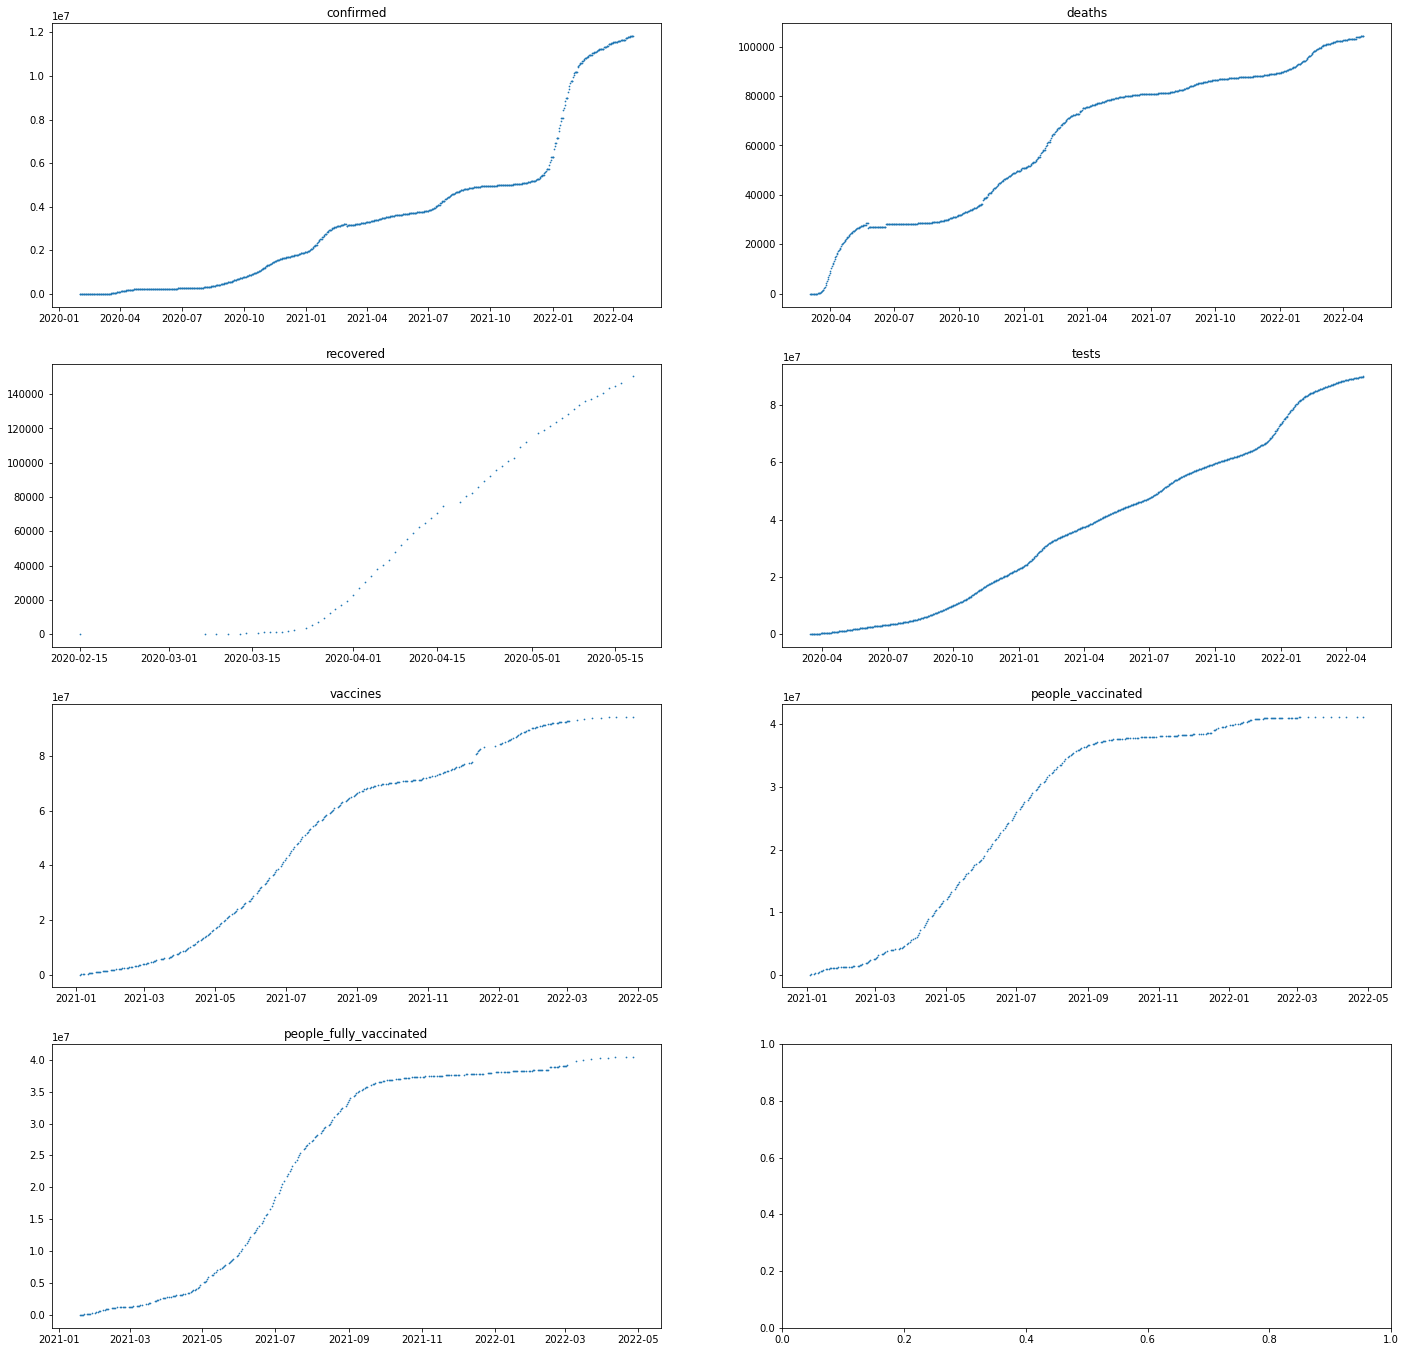

In [205]:
fig, ax = plt.subplots(4, 2, figsize=(24,24))

cols = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated']

for it, col in enumerate(cols):
    i = it // 2
    j = it % 2
    ax[i, j].scatter(spain['date'], spain[col], s=0.5)
    ax[i, j].set_title(col)

plt.show()

In [271]:
spain = spain.drop('recovered', axis=1)

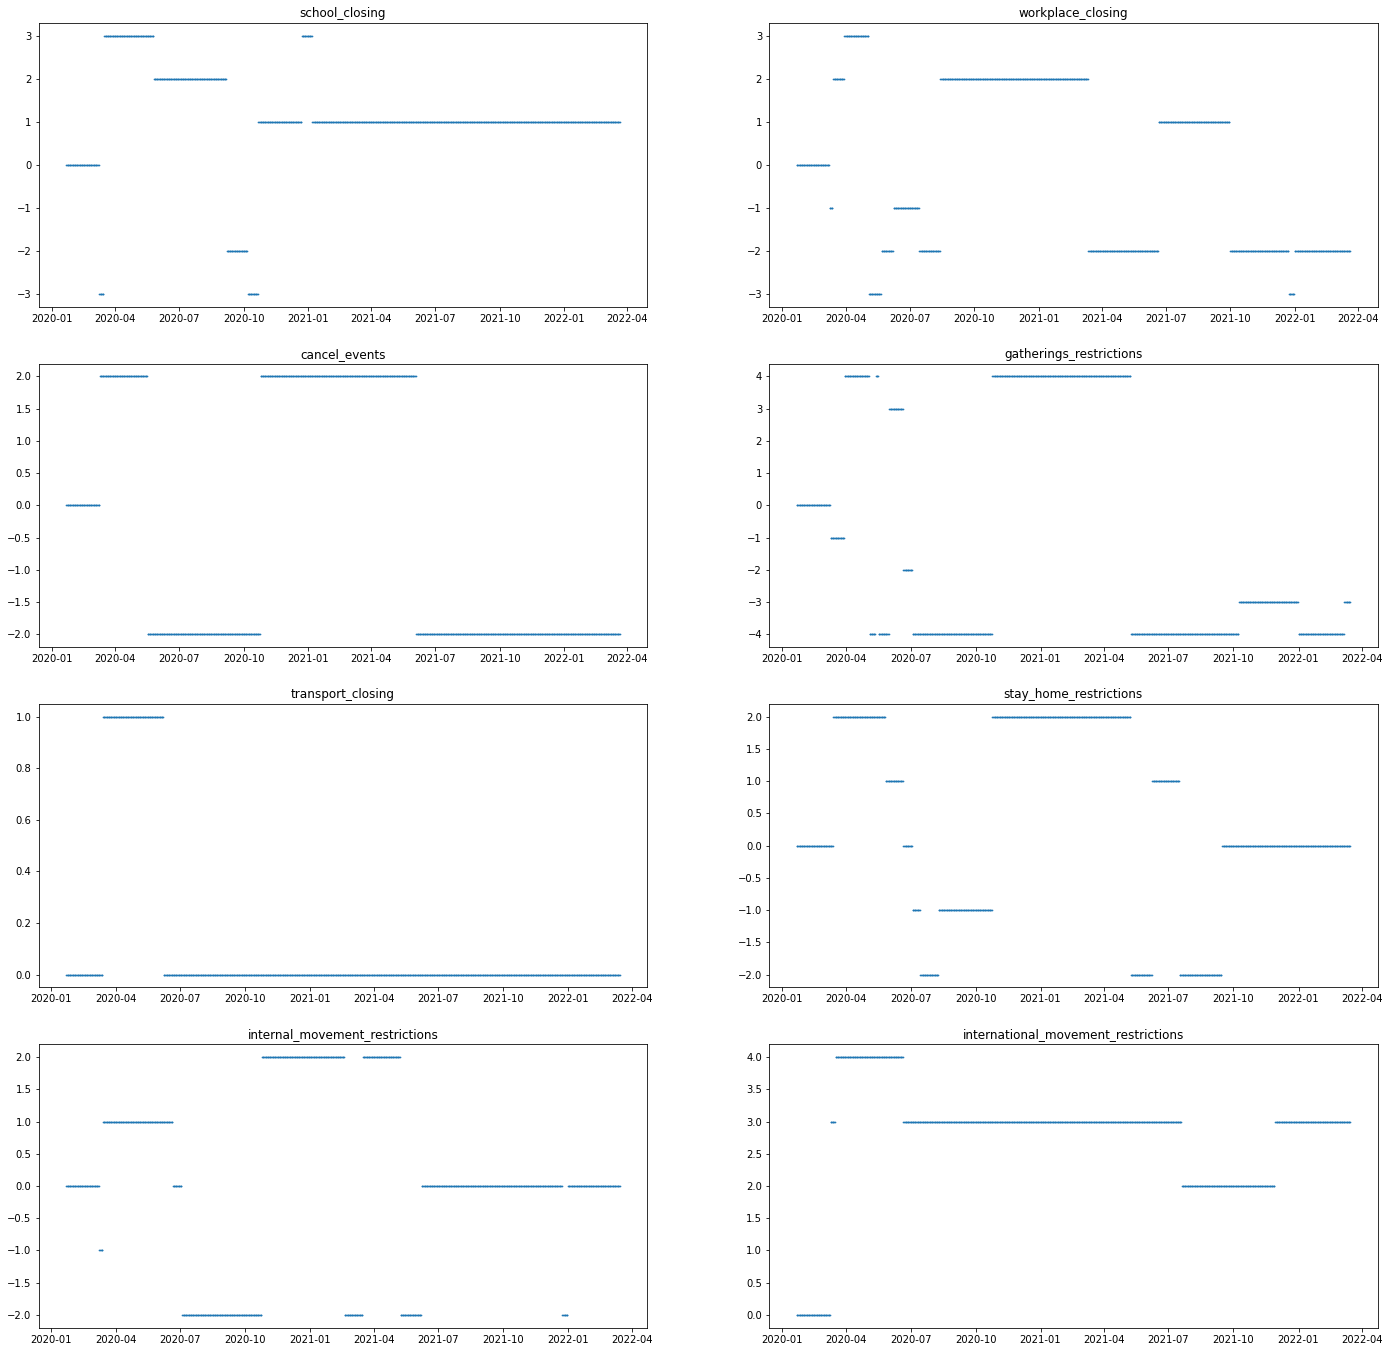

In [89]:
fig, ax = plt.subplots(4, 2, figsize=(24,24))

cols = ['school_closing', 'workplace_closing', 'cancel_events', 'gatherings_restrictions',
       'transport_closing', 'stay_home_restrictions', 'internal_movement_restrictions',
        'international_movement_restrictions']

for it, col in enumerate(cols):
    i = it // 2
    j = it % 2
    ax[i, j].scatter(spain['date'], spain[col], s=0.5)
    ax[i, j].set_title(col)

plt.show()

In [206]:
spain.columns

Index(['date', 'confirmed', 'deaths', 'recovered', 'tests', 'vaccines',
       'people_vaccinated', 'people_fully_vaccinated', 'school_closing',
       'workplace_closing', 'cancel_events', 'gatherings_restrictions',
       'transport_closing', 'stay_home_restrictions',
       'internal_movement_restrictions', 'international_movement_restrictions',
       'information_campaigns', 'testing_policy', 'contact_tracing',
       'facial_coverings', 'vaccination_policy', 'elderly_people_protection',
       'government_response_index', 'stringency_index',
       'containment_health_index', 'population'],
      dtype='object')

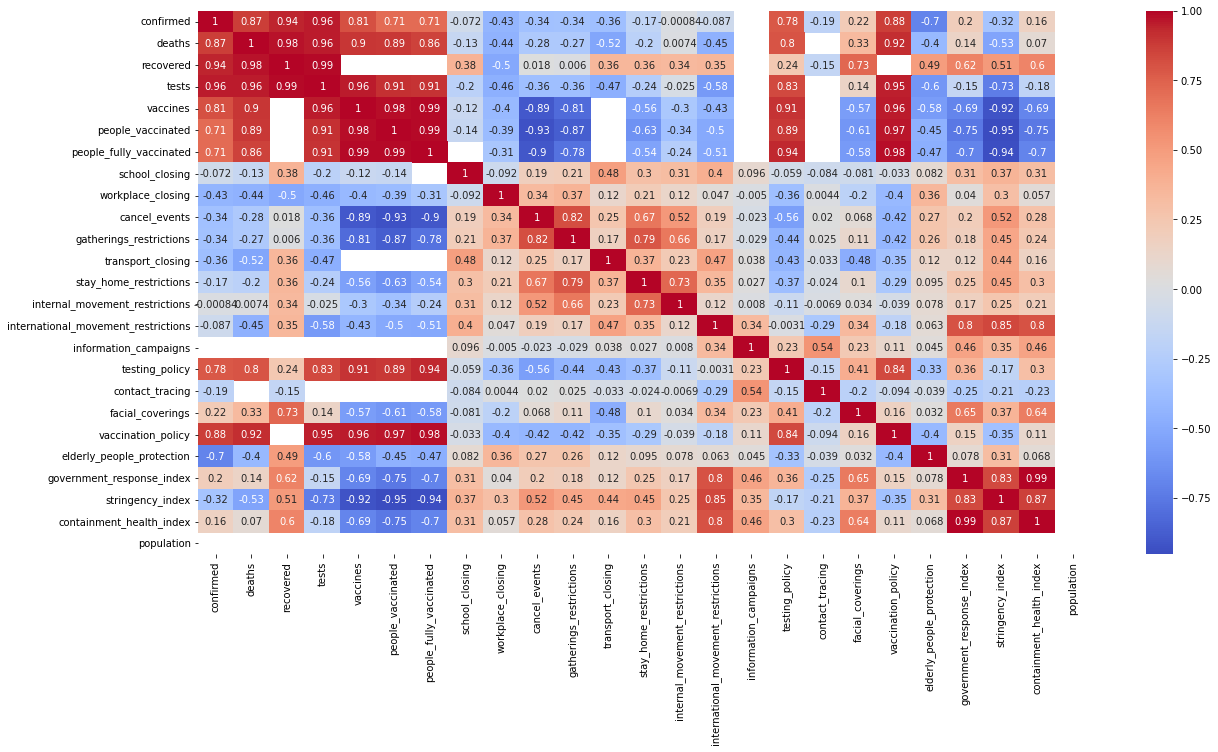

In [207]:
figure = plt.figure(figsize=(20, 10))
sns.heatmap(spain.corr(), annot=True, cmap= 'coolwarm')
plt.show()

In [122]:
world.tail(100)

,date,confirmed,deaths,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,school_closing,workplace_closing,...,testing_policy,contact_tracing,facial_coverings,vaccination_policy,elderly_people_protection,government_response_index,stringency_index,containment_health_index,economic_support_index,population
10239,2022-01-20,7957.0,70.0,7238.0,93604.0,68168.0,26584.0,25975.0,1.0,1.0,...,3.0,2.0,3.0,5.0,1.0,58.33,47.22,59.52,50.0,37910.0
10240,2022-01-21,8042.0,70.0,NaN,93886.0,68524.0,26591.0,25994.0,1.0,1.0,...,3.0,2.0,3.0,5.0,1.0,58.33,47.22,59.52,50.0,37910.0
10241,2022-01-22,8131.0,71.0,NaN,94142.0,68524.0,26592.0,25995.0,1.0,1.0,...,3.0,2.0,3.0,5.0,1.0,58.33,47.22,59.52,50.0,37910.0
10242,2022-01-23,8229.0,71.0,7612.0,94340.0,68524.0,26592.0,25995.0,1.0,1.0,...,3.0,2.0,3.0,5.0,1.0,58.33,47.22,59.52,50.0,37910.0
10243,2022-01-24,8405.0,71.0,7724.0,94671.0,68541.0,26594.0,25998.0,1.0,1.0,...,3.0,2.0,3.0,5.0,1.0,58.33,47.22,59.52,50.0,37910.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10334,2022-04-25,17101.0,82.0,16913.0,115471.0,70512.0,26727.0,26404.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37910.0
10335,2022-04-26,17101.0,82.0,16942.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37910.0
10336,2022-04-27,NaN,NaN,16948.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37910.0
10337,2022-04-28,NaN,NaN,16970.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37910.0


Braki danych (Spain):
- Zauważyłem, że wszystkie braki danych dla kolumn opisujących restrykcje i antycovidową politykę kraju występują od dnia 16/03/2022. W moim odczuciu może to być spowodowane przez kilka rzeczy:
    - powszechnie zauważalny trend do zmniejszania obostrzeń w tym czasie
    - dane za ten okres mogły nie zostać jeszcze odpowiednio przetworzone i wprowadzone do zbioru z Covid Data Hub
    - dane mogą nie być już tak pieczołowicie gromadzone jak to miało miejsce wcześniej

  Biorąc pod uwagę powyższe czynniki oraz fakt, że omawiane braki stanowią niewiele ponad 5% całego zestawu, a zbadanie ich wpływu na liczbę zachorowań i zgonów uważam za istotne, zdecydowałem się usunąć obserwacje z okresu po 16/03/2022.



- vaccines, people_vaccinated, people_fully_vaccinated: braki głównie w weekendy (na pewno?)
- restrykcje: braki danych pod koniec, tak samo dla wszystkich restrykcji. Można usunąć, lub zastąpić ostatnią znaną wartością?

In [208]:
idx = spain[spain['date'] == '2022-03-16'].index
row_num = spain.index.get_loc(idx[0])
spain_cut = spain.drop(spain.index[row_num:])

print(spain.shape, spain_cut.shape)

(830, 26) (784, 26)


In [209]:
spain_cut_nulls = 100 * spain_cut.isnull().sum() / spain_cut.shape[0]
spain_nulls = 100 * spain.isnull().sum() / spain.shape[0]

pd.DataFrame({
    'spain': spain_nulls,
    'spain_cut': spain_cut_nulls
})

,spain,spain_cut
date,0.000000,0.000000
confirmed,1.204819,1.275510
deaths,4.939759,5.229592
recovered,92.168675,91.709184
tests,6.867470,6.760204
vaccines,64.337349,63.137755
people_vaccinated,63.855422,62.627551
people_fully_vaccinated,64.698795,63.520408
school_closing,4.819277,0.000000
workplace_closing,4.819277,0.000000


In [210]:
spain = spain_cut

Powyższa tabela potwierdza, że po usunięciu obserwacji od 16/03/2022 udało się całkowicie wyeliminować braki danych dla wspomnianych kolumn. Przyjrzyjmy się ponownie wykresom:

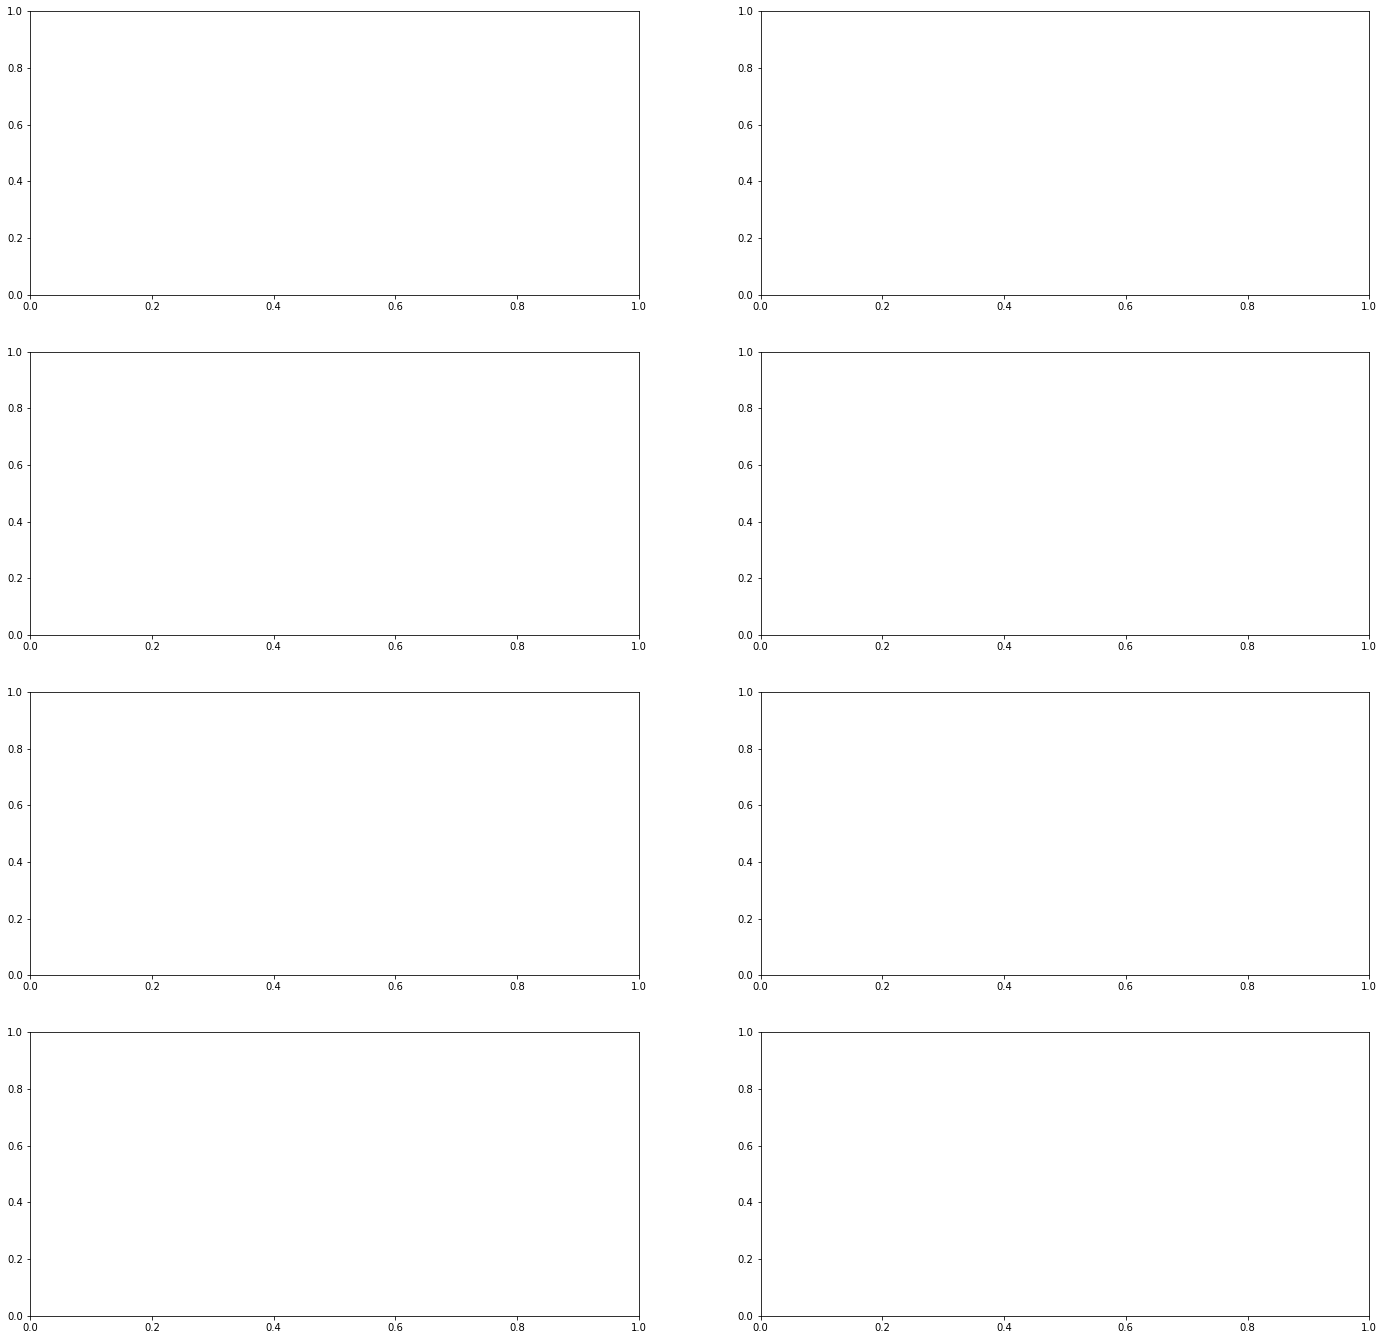

In [272]:
fig, ax = plt.subplots(4, 2, figsize=(24,24))

cols = [i for i in spain.columns if spain[i].isnull().any()]

for it, col in enumerate(cols):
    i = it // 2
    j = it % 2
    ax[i, j].scatter(spain['date'], spain[col], s=0.5)
    ax[i, j].set_title(col)

plt.show()

Dla danych z kolumny deaths możemy zaobserwować dziwne zjawisko. W okresie letnich miesięcy 2020 mamy fragment gdzie całkowita liczba odnotowanych zgonów spada w czasie. Jest to niemożliwe, ponieważ mówimy o parametrze skumulowanym, a więc takim który może tylko rosnąć. Sprawdzimy, czy podobne sytuacje występują dla innych skumulowanych parametrów.

In [212]:
columns_with_error = []
for col in cols:
    a = np.array(spain[col].dropna())
    if not np.all(a[:-1] <= a[1:]):
        columns_with_error.append(col)
print(columns_with_error)

['confirmed', 'deaths']


Widać, że opisany problem występuje w kolumnach 'confirmed' i 'deaths'. Dla pozostałych zmiennych skumulowanych, kolejne wartości są zawsze nie mniejsze od poprzednich. Pozostaje pytanie, jak postąpić z powyższym błędem. Zdecydowałem, że w miejscach gdzie wartości zaczynają spadać, zastąpię je ostatnim poprawnym odczytem.


In [213]:
for col in columns_with_error:
    a = np.array(spain[col])
    for i in range(1, spain.shape[0]):
        if a[i] < a[i-1]:
            a[i] = a[i-1]
    spain[col] = a

Sprawdzamy czy błąd został naprawiony.

In [214]:
columns_with_error = []
for col in cols:
    a = np.array(spain[col].dropna())
    if not np.all(a[:-1] <= a[1:]):
        columns_with_error.append(col)
print(columns_with_error)

[]


Jak widać pozbyliśmy się błędu. Zajmiemy się teraz brakami danych dla pozostałych cech. Duże braki danych występują dla zmiennych odpowiadających za szczepienia, ale wynika to z faktu że nie były one dostępne przez początkowy okres pandemii. W takiej sytuacji, naturalne wydaje się zastąpienie ich zerami, do momentu wystąpienia pierwszej wartości w tych kolumnach. Tak samo postępujemy dla kolumn 'confirmed' i 'deaths'.

In [215]:
cols = ['vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'confirmed', 'deaths']
spain[cols] = spain[cols].interpolate('zero', fill_value=0, limit_direction='backward')

In [268]:
100 * spain.isnull().sum() / spain.shape[0]

date                                    0.000000
confirmed                               0.000000
deaths                                  0.000000
recovered                              91.709184
tests                                   0.000000
vaccines                                0.000000
people_vaccinated                       0.000000
people_fully_vaccinated                 0.000000
school_closing                          0.000000
workplace_closing                       0.000000
cancel_events                           0.000000
gatherings_restrictions                 0.000000
transport_closing                       0.000000
stay_home_restrictions                  0.000000
internal_movement_restrictions          0.000000
international_movement_restrictions     0.000000
information_campaigns                   0.000000
testing_policy                          0.000000
contact_tracing                         0.000000
facial_coverings                        0.000000
vaccination_policy  

In [222]:
spain[cols + ['date']].tail(7)

,vaccines,people_vaccinated,people_fully_vaccinated,confirmed,deaths,date
174116,92774397.0,41083791.0,39103590.0,11181510.0,100992.0,2022-03-09
174117,93346088.0,41089269.0,39845453.0,11204125.0,101077.0,2022-03-10
174118,93346088.0,41089269.0,39845453.0,11223974.0,101135.0,2022-03-11
174119,93346088.0,41089269.0,39845453.0,11223974.0,101135.0,2022-03-12
174120,93346088.0,41089269.0,39845453.0,11223974.0,101135.0,2022-03-13
174121,93346088.0,41089269.0,39845453.0,11223974.0,101135.0,2022-03-14
174122,93346088.0,41089269.0,39845453.0,11260040.0,101416.0,2022-03-15


Udało się znacznie ograniczyć braki, zostały tylko w 5 ostatnich wierszach dla danych o szczepionkach. Dla tych wartości przeprowadzimy prostą interpolację liniową, zakładając że tempo szczepień utrzymywało się w tym czasie. Takie przybliżenie może być obarczone pewnym błędem, ale jest na pewno lepszym rozwiązaniem niż uzupełnianie braków ostatnią znaną wartością, ponieważ opierałoby się to na przesłankach że ludzie nagle całkowicie przestali się szczepić, co nie jest prawdą. Aby wziąć pod uwagę trend szczepień w interesujacym nas okresie, a nie z całego przebiegu pandemii, zawężymy liczbę wierszy używanych do interpolacji do dwóch miesięcy.

In [224]:
spain.loc[-60:, cols] = spain.loc[-60:, cols].interpolate('linear')

In [245]:
i = spain.tests.first_valid_index()
ratio = spain['tests'][i:i+14]/spain['confirmed'][i:i+14]
ratio

53    0.808284
54    1.544257
55    2.301924
56    2.862329
57    3.047264
58    3.474375
59    3.355403
60    3.385776
61    3.279656
62    3.440867
63    3.255014
64    3.230627
65    3.235001
66    3.183109
dtype: float64

W przypadku testów, policzyliśmy stosunek liczby wykonany testów do potwierdzonych przypadków w pierwszych 2 tygodniach kiedy mamy dane z testów. Widzimy że pierwsza wartość (0.808) musi być błędna, ponieważ sugerowałaby że wykonano mniej testów niż potwierdzono przypadków. Wartość z 55. wiersza (2.30) jest już jak najbardziej możliwa i tej wartości użyjemy do uzupełnienia braków z początku. Zakładamy więc, że stosunek wykonywanych testów do liczby potwierdzonych przypadków był względnie stały przez pierwsze dni pandemii.

In [257]:
spain.loc[:i+4,'tests'] = (spain['confirmed'][:i+5] * ratio[i+2]).astype(int)

In [258]:
spain.head(60)

,date,confirmed,deaths,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,school_closing,workplace_closing,...,information_campaigns,testing_policy,contact_tracing,facial_coverings,vaccination_policy,elderly_people_protection,government_response_index,stringency_index,containment_health_index,population
0,2020-01-22,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,46796540.0
1,2020-01-23,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,46796540.0
2,2020-01-24,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.08,0.00,2.38,46796540.0
3,2020-01-25,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.08,0.00,2.38,46796540.0
4,2020-01-26,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.08,0.00,2.38,46796540.0
5,2020-01-27,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.08,0.00,2.38,46796540.0
6,2020-01-28,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.08,0.00,2.38,46796540.0
7,2020-01-29,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.08,0.00,2.38,46796540.0
8,2020-01-30,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.08,0.00,2.38,46796540.0
9,2020-01-31,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,2.0,0.0,0.0,0.0,14.58,11.11,16.67,46796540.0


In [273]:
spain.isnull().sum()

date                                   0
confirmed                              0
deaths                                 0
tests                                  0
vaccines                               0
people_vaccinated                      0
people_fully_vaccinated                0
school_closing                         0
workplace_closing                      0
cancel_events                          0
gatherings_restrictions                0
transport_closing                      0
stay_home_restrictions                 0
internal_movement_restrictions         0
international_movement_restrictions    0
information_campaigns                  0
testing_policy                         0
contact_tracing                        0
facial_coverings                       0
vaccination_policy                     0
elderly_people_protection              0
government_response_index              0
stringency_index                       0
containment_health_index               0
population      

Pozbyliśmy się braków danych dla Hiszpanii.